Some of the ideas are taken from very good explorations in https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python and https://lstrln.wordpress.com/2017/09/13/predicting-house-prices-on-kaggle-a-gentle-introduction-to-data-science-part-i/.

https://www.kaggle.com/mgmarques/houses-prices-complete-solution/comments#notebook-container

**TODO:**
- Add indicator variables (e.g. has basement) to take away some effect of many zeros
- Collapse rare categories
- Check regression assumptions
- Some feature engineering
- Modelling
    - Simple linear regression; ridge/lasso/elastic-net
    - Mixed effects models (random intercept for year/neighbourhood)
    - Tree-based methods
   

# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import boxcox
from scipy.stats import probplot
from IPython.display import display


In [2]:
pd.options.display.max_columns = None
%matplotlib inline

In [3]:
initial_train = pd.read_csv('train.csv')
initial_test = pd.read_csv('test.csv')

* outliers
* regression assumptions
* simple imputation of missings
* modelled imputation of missings ('lot' variables)
* merge small categories
* ordinal features

# Exploratory data analysis

## Our data structure

In [4]:
print("Shape of train dataframe: " + str(initial_train.shape))
print("Number of distinct Id values: " + str(initial_train.Id.nunique()))

Shape of train dataframe: (1460, 81)
Number of distinct Id values: 1460


The are 1460 observations with a target called 'SalePrice' and a unique 'Id' variable which can be dropped.

In [5]:
initial_train.drop('Id', axis=1, inplace=True)
initial_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


This is what the first few rows show us. While there are too many variables to go through at this stage, we can see there are a range of variables with missing values, as well as numerous categorical variables (as can be seen in the accompanying data_description.txt file).

In [6]:
col_types = initial_train.dtypes
col_types.groupby(col_types).size()

int64      34
float64     3
object     43
dtype: int64

A reasonable number of our features (36 excepting the target variable 'SalesPrice') are numerical, however 43 are not.

In [7]:
missing_values = initial_train.isnull().mean()
missing_values[(missing_values.index.isin(col_types[col_types==object].index)) & (missing_values>0)].sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
GarageCond      0.055479
GarageQual      0.055479
GarageFinish    0.055479
GarageType      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

In [8]:
missing_values[(missing_values.index.isin(col_types[col_types!=object].index)) & (missing_values>0)].sort_values(ascending=False)

LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
dtype: float64

There are 19 variables with missing values, only three of which are numeric. Most of them only have a small (less than 5% or so) percentage missing, whilst there are several others such as 'PoolQC' with the vast majority missing.

* Note that there appear to be three groups of variables which have missing values for their group's other variables when one of the group's variables is missing. These are related to the garage, basement, and masonary. However, the former two have multiple other variables in their group which have no missing values (e.g. 'BsmtFinSF1' and 'BsmtFinSF2', and 'GarageCars' and 'GarageArea'); we may be able to impute using this.
* There is a similar story for 'FireplaceQu' ('Fireplaces') and 'PoolQC' ('PoolArea') which have many missing values. Again we may be able to somewhat reliably impute using these, especially as large percentages of each are missing
* 'MiscFeature' is mostly missing. There is a category for 'none', but less than 4% have any of the five other specified categories so we'd likely need to assume these missing values also represent 'none'
* 'LotFrontage' also has a non-negligible number of missing entries. However, we may be able to see if there is a relationship with 'LotArea', 'LotConfig', and 'LotShape' which we may be able to use to model to estimate the missing values.
* 'Alley' is less clear; like 'MiscFeature' this may just be a case of setting them as 'NA'
* 'Fence' is similar to 'Alley'
* 'Electrical' has less than 0.1% missing, or one observation, meaning it would be best to either drop this observation or use the average value 

## A more detailed look

Now we understand the structure of our data a bit better, we can start looking at individual variables, and attempt to look at their individual distributions and correlations. 

### Dependent variable 'SalePrice'
It makes sense to start with the target variable.

In [9]:
print(col_types['SalePrice'])

int64


As expected (this is a regression problem!), we have numerical response variable. But what does the range of values look like?

In [10]:
initial_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0,0.5,'Proportion')

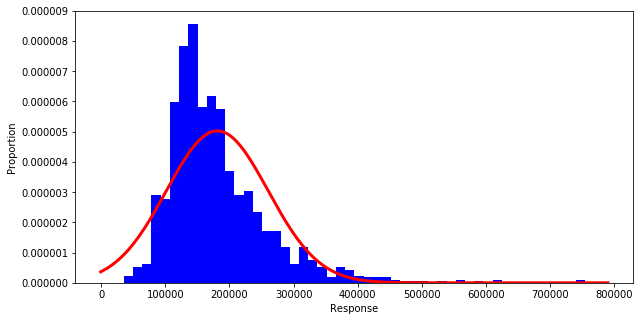

In [11]:
mean, std = norm.fit(initial_train['SalePrice'])

fig = plt.figure(figsize=(10, 5))
#initial_train['SalePrice'].hist(bins=50)
plt.hist(initial_train['SalePrice'], color='b', bins=50, density=True)
lim_xmin, lim_xmax = plt.xlim()
xvals = np.linspace(lim_xmin, lim_xmax, 200)
plt.plot(xvals, norm.pdf(xvals, mean, std), color='r', linewidth=3)
plt.xlabel('Response')
plt.ylabel('Proportion')

This is definitely not normal (-ly distributed)! We might want to look into performing a log transformation on this a bit later if we have issues with linearity.

## Modifying the data and feature engineering
Before we go ahead and fit models to this data, first we need to do a couple of things:
1) Ensure that, especially for regression, key assumptions are met by the data to make sure the model is valid and reliable
2) Create new features to improve the model accuracy

### Dependent variable
One of the key assumptions of regression is that the distribution of errors is normal. Though not essential, it is also beneficial that the dependent variable is normal as it reduces the chances of other regression assumptions being violated (including linearity).

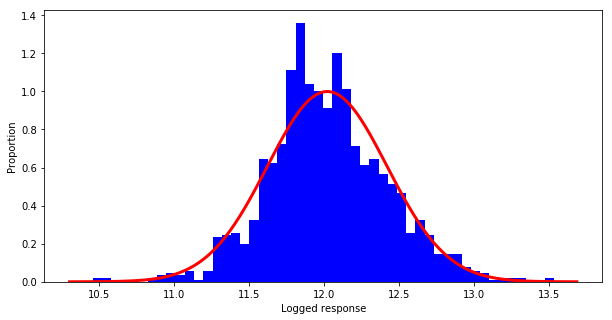

In [12]:
initial_train['LogSalePrice'] = np.log(initial_train['SalePrice'])
#initial_test['LogSalePrice'] = np.log(initial_test['SalePrice'])

mean, std = norm.fit(initial_train['LogSalePrice'])

fig = plt.figure(figsize=(10, 5))
plt.hist(initial_train['LogSalePrice'], color='b', bins=50, density=True)
lim_xmin, lim_xmax = plt.xlim()
xvals = np.linspace(lim_xmin, lim_xmax, 200)
plt.plot(xvals, norm.pdf(xvals, mean, std), color='r', linewidth=3)
plt.xlabel('Logged response')
plt.ylabel('Proportion')
plt.show()

This is much closer to a normal distribution. As a result, we will consider this as our new dependent variable as we can do the inverse transform (exponentiation) to get the price back in terms of dollars. At this point I will also drop the original 'SalePrice' variable so we don't accidentally include it in our model.

In [13]:
initial_train.drop(columns='SalePrice', inplace=True)

### Relationship between variables

In [14]:
cols_numeric = list(initial_train.select_dtypes(include=np.number).columns)
cols_cat = list(initial_train.select_dtypes(include=object).columns)

print("Number of numeric features: {}".format(len(cols_numeric) - 1))
print("Number of categorical (non-numeric) features: {}".format(len(cols_cat)))

Number of numeric features: 36
Number of categorical (non-numeric) features: 43


There are a mix of numeric and categorical features. However, before proceding it is worth checking whether any numeric variables are really categories encoded as numbers. Similarly, I will look for ordinal features in the numeric list to keep an eye on.

A reminder of the numeric columns:

In [15]:
print(cols_numeric)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'LogSalePrice']


According to the accompanying data description, `MSSubClass` should be considered a categorical variable as the numeric encodings are not appropriately ordered. The various year variables may also be categorical for this reason, as is the `MoSold`.

Ordinal features include `OverallQual`, `OverallCond` in the numeric variables. For the categorical variables, `Utilities` (potentially), `LandSlope` (this may quite easily be non-linear as potentially a medium slope may be preferable to buyers), `ExterQual`, `ExterCond`, `HeatingQC`, `KitchenQual`, and `PavedDrive` could be considered or mapped to be ordinal (none of these include N/A or missing entries such as `BsmtFinType1`). The other categorical variables should be considered as such and will need to be dealt with appropriately whereas those above may be mapped to numeric variables to reduce dimensionality. Note a couple of the other categorical variables are binary. 

In [16]:
cols_cat += ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']
cols_numeric.remove('MSSubClass')
cols_numeric.remove('MoSold')
cols_numeric = [col for col in cols_numeric if col not in ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']]
print("Number of numeric features: {}".format(len(cols_numeric) - 1))
print("Number of categorical (non-numeric) features: {}".format(len(cols_cat)))

Number of numeric features: 30
Number of categorical (non-numeric) features: 49


#### Categorical features
I will start with categorical features.

** POTENTIAL RANDOM EFFECTS: YEAR(S), NEIGHBOURHOOD **

In [17]:
print(cols_cat)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'MoSold']


First let's investigate each values of each categorical variable in terms of its relationship with the response.

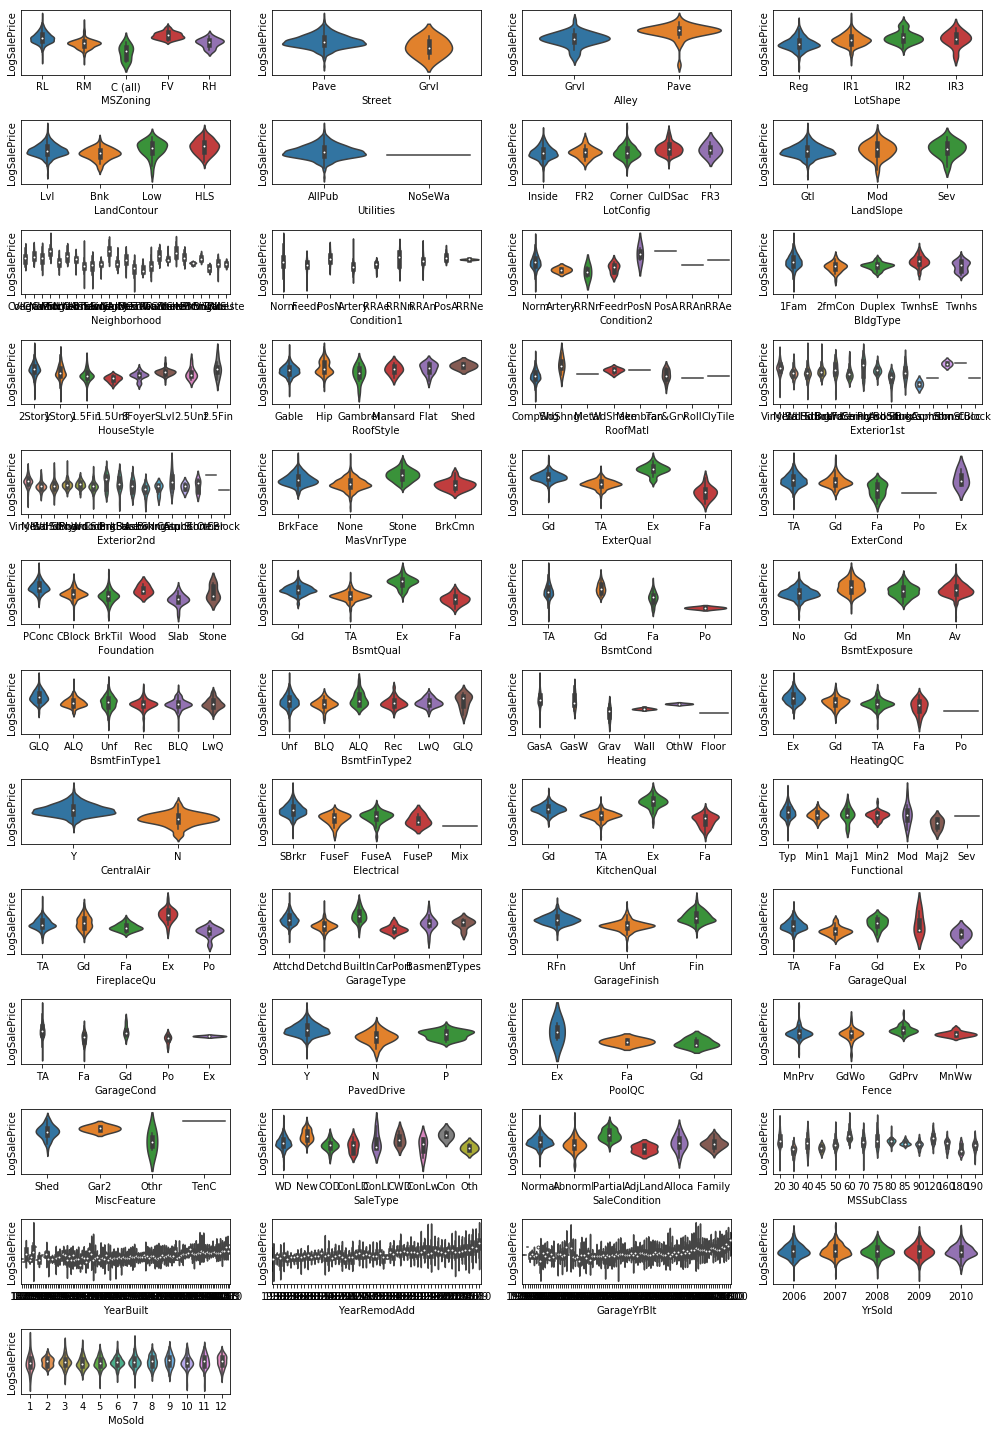

In [18]:
n_cols = 4
n_rows = int(np.ceil(len(cols_cat) / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, 20))

for a in ax.ravel():
     a.set_yticks([])

id_row = 0
id_col = 0
for i, sp in enumerate(cols_cat):

    sns.violinplot(x=sp, y='LogSalePrice', data=initial_train, ax=ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
    
    
for k in np.arange(i - 1, n_rows * n_cols - 2):
    
    fig.delaxes(ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
        
    
        
plt.tight_layout()
plt.show()

There is a lot to digest from this. I will try to unpack this below. The above plot, while full-on, is useful to get a quick understanding of each categorical variable. If there were many more it would become too difficult to read and I would have to think further how to display this.
* **Suggested ordinal variables**: `Utilities` , `LandSlope`, `ExterQual`, `ExterCond`, `HeatingQC`, `KitchenQual`, and `PavedDrive` were mentioned as possibly being able to be converted to a numeric variable due to possible ordinalities (their values containing Excellent, Good, etc.). From the plots, we can see that `Utilities` only has two of its possible four values suggested by the data description in the training set - we need to bear this in mind as they may appear in the test set. We cannot tell from this whether this would be a good ordinal feature (or even a good feature at all!). `LandSlope`, `ExterQual`, `ExterCond`, `HeatingQC`, `KitchenQual`, and `PavedDrive` all appear to be resonable candidates for ordinal features.
* **Years**: The year variables generally appear to have a small upward trend - the newer the house/garage, or remodelling the larger the price. For this reason, I will switch these back to be numeric. The year sold variable does not adhere to this trend, albeit there are fewer years.
* **Month**: The `MoSold` variable may be cyclic in nature (though it is hard to tell from this plot). Therefore I will reconvert it to a numeric column.
* **Other features**: Some, but not all, of the other features appear to have reasonable correlation with the response, though many of their values spreads are quite large. `Neighborhood` for example looks to be useful.

In [19]:
cols_numeric += ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold']
cols_cat = [col for col in cols_cat if col not in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold']]
print("Number of numeric features: {}".format(len(cols_numeric) - 1))
print("Number of categorical (non-numeric) features: {}".format(len(cols_cat)))

Number of numeric features: 34
Number of categorical (non-numeric) features: 45


#### Dealing with missing values
As shown earlier we have missing valiues for several categorical variables. I will deal with them here for both training and test datasets.

In [20]:
missing_values_train = initial_train.isnull().sum()
print("Missing in training set: " + str(missing_values_train[(missing_values_train.index.isin(col_types[col_types==object].index)) &
                     (missing_values_train>0)].sort_values(ascending=False)))

print("-" * 30)
missing_values_test = initial_test.isnull().sum()
print("Missing in test set: " + str(missing_values_test[(missing_values_test.index.isin(col_types[col_types==object].index)) &
                     (missing_values_test>0)].sort_values(ascending=False)))

Missing in training set: PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
GarageCond        81
GarageQual        81
GarageFinish      81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrType         8
Electrical         1
dtype: int64
------------------------------
Missing in test set: PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType2      42
BsmtFinType1      42
MasVnrType        16
MSZoning           4
Utilities          2
Functional         2
KitchenQual        1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64


##### PoolQC

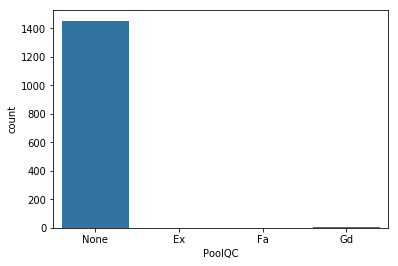

In [21]:
sns.countplot(x='PoolQC', data=initial_train.fillna('None'))

The overwhelming majority of properties have no pool, so it makes sense to drop this variable (and the corresponding `PoolArea`).

In [22]:
initial_train.drop(columns=['PoolQC', 'PoolArea'], inplace=True)
initial_test.drop(columns=['PoolQC', 'PoolArea'], inplace=True)

##### MiscFeature
Here I will simply create a replacement variable with value 1 if the property has a misc feature and 0 otherwise. This is because the plot above suggests (other than potentially the 'other' value), this leads to a somewhat inflated price. We also have the problem that the vast majority are missing otherwise.

In [23]:
initial_train['HasMiscFeature'] = np.where(initial_train['MiscFeature'].isna(), 0, 1)
initial_test['HasMiscFeature'] = np.where(initial_test['MiscFeature'].isna(), 0, 1)
initial_train.drop(columns=['MiscFeature'], inplace=True)
initial_test.drop(columns=['MiscFeature'], inplace=True)

##### Alley:

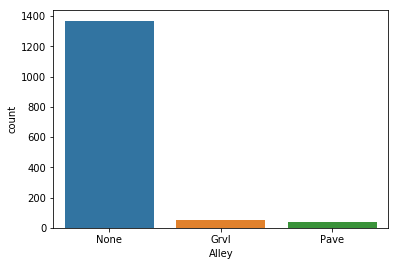

In [24]:
sns.countplot(x='Alley', data=initial_train.fillna('None'))

I will simply replace the missings with another category ('none'). Note though that the are few alleys so this approach may potentially lead to some overfitting. Otherwise I could do what I did for `MiscFeature`.

In [25]:
initial_train['Alley'].fillna('None', inplace=True)
initial_test['Alley'].fillna('None', inplace=True)

##### Fence:
I will simply do what I did for `MiscFeature`.

In [26]:
initial_train['HasFence'] = np.where(initial_train['Fence'].isna(), 0, 1)
initial_test['HasFence'] = np.where(initial_test['Fence'].isna(), 0, 1)
initial_train.drop(columns=['Fence'], inplace=True)
initial_test.drop(columns=['Fence'], inplace=True)

##### FireplaceQu
I will again set missings to be a new category of 'None'.

In [27]:
initial_train['FireplaceQu'].fillna('None', inplace=True)
initial_test['FireplaceQu'].fillna('None', inplace=True)

##### Basement and garage variables
I will assume missing values means the property doesn't have these, hence I will set a new value for none for each of the related variables.

In [28]:
initial_train['GarageType'].fillna('None', inplace=True)
initial_train['GarageFinish'].fillna('None', inplace=True)
initial_train['GarageQual'].fillna('None', inplace=True)
initial_train['GarageCond'].fillna('None', inplace=True)
initial_test['GarageType'].fillna('None', inplace=True)
initial_test['GarageFinish'].fillna('None', inplace=True)
initial_test['GarageQual'].fillna('None', inplace=True)
initial_test['GarageCond'].fillna('None', inplace=True)
# Remove this as it was changed back to numeric but still has missing values
initial_train.drop(columns=['GarageYrBlt'], inplace=True)
initial_test.drop(columns=['GarageYrBlt'], inplace=True)


initial_train['BsmtQual'].fillna('None', inplace=True)
initial_train['BsmtCond'].fillna('None', inplace=True)
initial_train['BsmtFinType1'].fillna('None', inplace=True)
initial_test['BsmtQual'].fillna('None', inplace=True)
initial_test['BsmtCond'].fillna('None', inplace=True)
initial_test['BsmtFinType1'].fillna('None', inplace=True)
# There are a few more missing values compared to the above which is surprising. I will follow the same method as there
# are very few extra.
initial_train['BsmtExposure'].fillna('None', inplace=True)
initial_train['BsmtFinType2'].fillna('None', inplace=True)
initial_test['BsmtExposure'].fillna('None', inplace=True)
initial_test['BsmtFinType2'].fillna('None', inplace=True)

##### MasVnrType
I will simply assume if missing, this should be in the existing 'None' level (there are very few missing here).

In [29]:
initial_train['MasVnrType'].fillna('None', inplace=True)
initial_test['MasVnrType'].fillna('None', inplace=True)

##### Electrical
As previously discussed, there are so few missings for this I will simply drop the observation(s).

In [30]:
initial_train.dropna(subset=['Electrical'], inplace=True)

#### Variables missing in only the test set
Here I will simply replace the missings with the modal category in the training set, seeing as there are so few missing values.

In [31]:
missing_values_test = initial_test.isnull().sum()
print("Missing in test set: " + str(missing_values_test[(missing_values_test.index.isin(col_types[col_types==object].index)) &
                     (missing_values_test>0)].sort_values(ascending=False)))

Missing in test set: MSZoning       4
Functional     2
Utilities      2
SaleType       1
KitchenQual    1
Exterior2nd    1
Exterior1st    1
dtype: int64


In [32]:
#initial_test.loc[initial_test['MSZoning'].isna(), 'MSZoning'] = initial_train['MSZoning'].mode()
initial_test['MSZoning'].fillna(initial_train['MSZoning'].mode().to_string(index=False), inplace=True)
initial_test['Functional'].fillna(initial_train['Functional'].mode().to_string(index=False), inplace=True)
initial_test['Utilities'].fillna(initial_train['Utilities'].mode().to_string(index=False), inplace=True)
initial_test['SaleType'].fillna(initial_train['SaleType'].mode().to_string(index=False), inplace=True)
initial_test['KitchenQual'].fillna(initial_train['KitchenQual'].mode().to_string(index=False), inplace=True)
initial_test['Exterior2nd'].fillna(initial_train['Exterior2nd'].mode().to_string(index=False), inplace=True)
initial_test['Exterior1st'].fillna(initial_train['Exterior1st'].mode().to_string(index=False), inplace=True)

In [33]:
missing_values_train = initial_train.isnull().sum()
print("Missing in training set: " + str(missing_values_train[(missing_values_train.index.isin(col_types[col_types==object].index)) &
                     (missing_values_train>0)].sort_values(ascending=False)))


print("-" * 30)
missing_values_test = initial_test.isnull().sum()
print("Missing in test set: " + str(missing_values_test[(missing_values_test.index.isin(col_types[col_types==object].index)) &
                     (missing_values_test>0)].sort_values(ascending=False)))

Missing in training set: Series([], dtype: int64)
------------------------------
Missing in test set: Series([], dtype: int64)


#### Creating ordinal variables
I am going to assume the intervals between the values (e.g. Excellent, Good, etc.) are constant so I can convert the aforementioned ordinal categoric variables to numeric ones.

In [34]:
ordinal_dict1 = {'Ex': 0,
                 'Gd': 1,
                 'TA': 2,
                 'Fa': 3,
                 'Po': 4}
ordinal_dict2 = {'Y': 0,
                 'P': 1,
                 'N': 2}

initial_train.replace({'ExterQual': ordinal_dict1,
              'ExterCond': ordinal_dict1,
              'HeatingQC': ordinal_dict1,
              'KitchenQual': ordinal_dict1,
              'PavedDrive': ordinal_dict2}, inplace=True)

initial_test.replace({'ExterQual': ordinal_dict1,
              'ExterCond': ordinal_dict1,
              'HeatingQC': ordinal_dict1,
              'KitchenQual': ordinal_dict1,
              'PavedDrive': ordinal_dict2}, inplace=True)

cols_numeric += ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PavedDrive']
cols_cat = [col for col in cols_cat if col not in ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'PavedDrive']]
print("Number of numeric features: {}".format(len(cols_numeric) - 1))
print("Number of categorical (non-numeric) features: {}".format(len(cols_cat)))

Number of numeric features: 39
Number of categorical (non-numeric) features: 40


#### Encoding categoricals
I will now one hot encode the remaining categorical variables. Note I will make a separate dataset containing copies of the originals in case I come back and attempt mixed-effects models (treating a categorical variable as for example a randomly varying intercept) or want to try alternative methods of encoding the variables (see https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159 for example).

In [35]:
remaining_cat_cols = [col for col in cols_cat if col in initial_train.columns]
remaining_num_cols = [col for col in cols_numeric if col in initial_train.columns]
original_cat_vars_train = initial_train[remaining_cat_cols].copy()
original_cat_vars_test = initial_test[remaining_cat_cols].copy()

In [36]:
el_train = initial_train.shape[0]
initial_combined_pre_ohe = pd.concat((initial_train[remaining_cat_cols], initial_test[remaining_cat_cols]))
initial_combined_pre_ohe.shape

# To ensure we have the equivalent columns in the train and test sets (i.e. some categorical variable values could appear in one
# set and not the other), temporarily concatenate the datasets.
combined_ohe = pd.get_dummies(initial_combined_pre_ohe, columns=remaining_cat_cols)
train_ohe = combined_ohe.iloc[:el_train, :]
test_ohe = combined_ohe.iloc[el_train:, :]
del combined_ohe, initial_combined_pre_ohe

In [37]:
train_ohe.shape

(1459, 252)

#### Between 'SalePrice' and numeric features

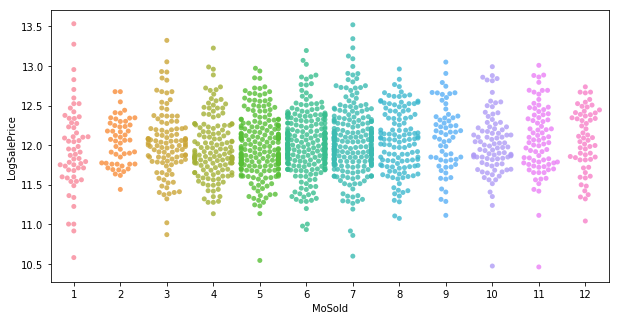

In [38]:
fig = plt.figure(figsize=(10, 5))

sns.swarmplot(data=initial_train, x='MoSold', y='LogSalePrice', alpha=0.8)

plt.show()

In [39]:
initial_train['MoSold_cos'] = np.cos(2 * np.pi * initial_train['MoSold'] / 12)
initial_train['MoSold_sin'] = np.sin(2 * np.pi * initial_train['MoSold'] / 12)
initial_train.drop(columns=['MoSold'], inplace=True)

initial_test['MoSold_cos'] = np.cos(2 * np.pi * initial_test['MoSold'] / 12)
initial_test['MoSold_sin'] = np.sin(2 * np.pi * initial_test['MoSold'] / 12)
initial_test.drop(columns=['MoSold'], inplace=True)

remaining_num_cols = remaining_num_cols + ['MoSold_cos', 'MoSold_sin']
remaining_num_cols.remove('MoSold')

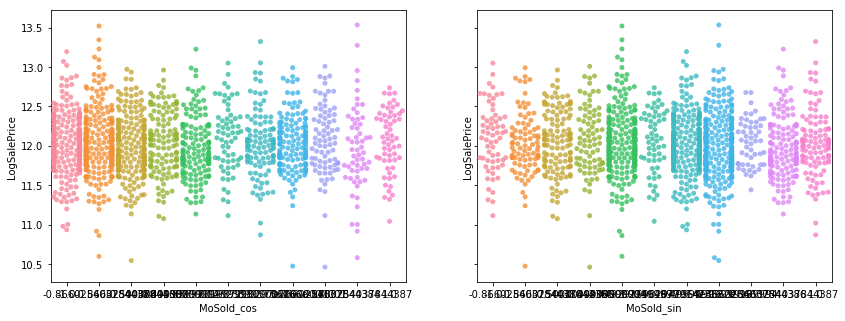

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.swarmplot(data=initial_train, x='MoSold_cos', y='LogSalePrice', alpha=0.8, ax=ax1)
sns.swarmplot(data=initial_train, x='MoSold_sin', y='LogSalePrice', alpha=0.8, ax=ax2)

#plt.legend()
plt.show()


### Linearity with the response
For the numeric columns, first I want to check the relationship with each to the response. This can give us a bivariate view of our data. We will quantify the relationship a bit later, but first let's plot each numeric variable against the response. At the same time I will plot a simple regression line for each plot and determine the r-square value as a quick measure of fit. I will keep this simple (including finding the r-squared using the training data) as this is merely done to aid visualisation, rather than perform any kind of concrete prediction.

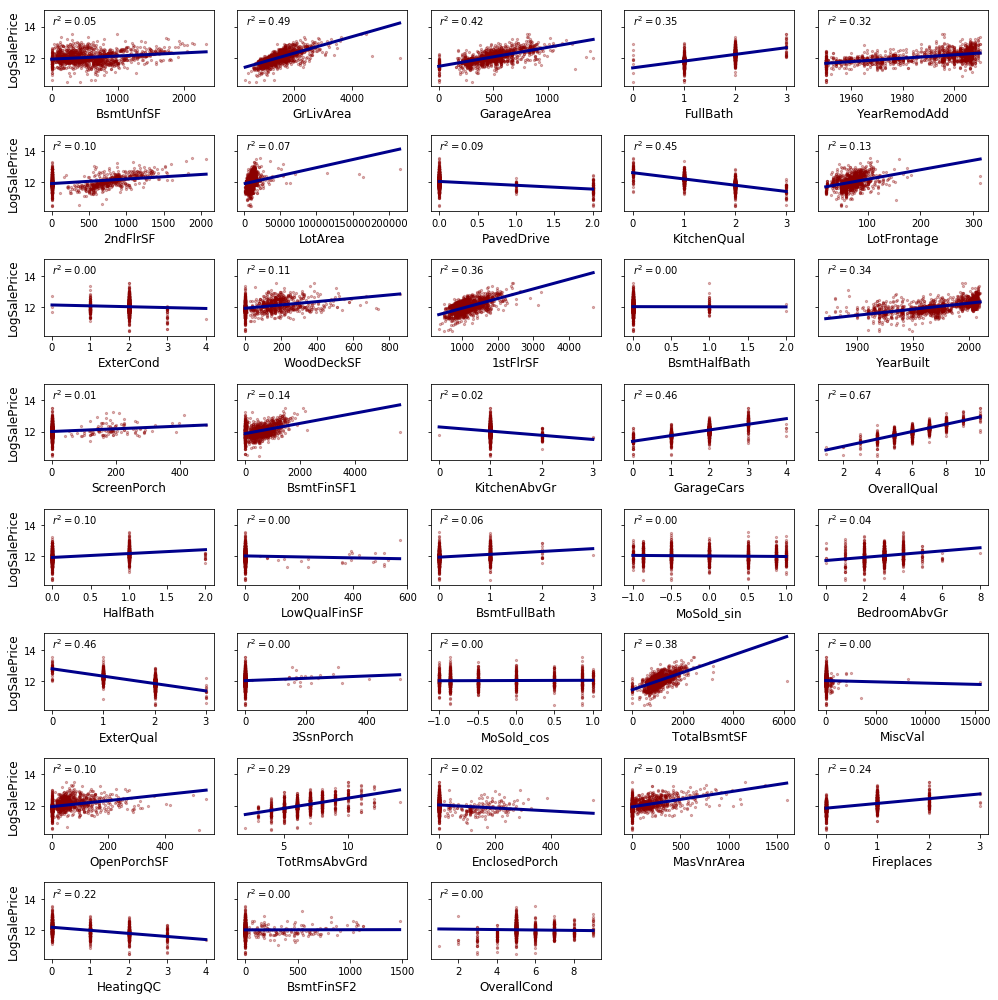

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

n_cols = 5
n_rows = int(np.ceil(len(remaining_num_cols) / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, 14), sharey=True)

# for a in ax.ravel():
#      a.set_yticks([])

id_row = 0
id_col = 0
ax[id_row, id_col].set_ylabel('LogSalePrice', fontsize=12)
for i, sp in enumerate({var for var in remaining_num_cols if var != 'LogSalePrice'}):
    
    x_train = initial_train[sp].values
    use_logic = np.isfinite(x_train)
    x_train = x_train[use_logic]
    y_train = initial_train['LogSalePrice'].values[use_logic]
    x_min, x_max = x_train.min(), x_train.max()
    lr = LinearRegression()
    lr.fit(x_train.reshape(-1, 1), y_train)
    preds_train = lr.predict(x_train.reshape(-1, 1))
    r2_val = r2_score(y_train, preds_train)
    y_lbf_low, y_lbf_high = lr.predict(np.array([x_min, x_max]).reshape(-1, 1))
    
    ax[id_row, id_col].scatter(initial_train[sp], initial_train['LogSalePrice'], color='darkred', alpha=0.3, s=5)
    ax[id_row, id_col].set_xlabel(sp, fontsize=12)
    ax[id_row, id_col].plot([x_min, x_max], [y_lbf_low, y_lbf_high], color='darkblue', linewidth=3)
    ax[id_row, id_col].text(0.05, 0.8, '$r^{} = {:.2f}$'.format(2, r2_val), transform=ax[id_row, id_col].transAxes)

    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
        if i < (n_cols * n_rows - 1):
            ax[id_row, id_col].set_ylabel('LogSalePrice', fontsize=12)
    else:
        id_col += 1
    
    
for k in np.arange(i - 1, n_rows * n_cols - 2):
    
    fig.delaxes(ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
        
    
        
plt.tight_layout()
plt.show()

Here we can see we have some reasonably strong relationships between several predictors and the log sales price. Most notably, the `OverallQual`, `ExterQual`, `GrLivArea`, `GarageCars` seem to be somewhat well correlated with the response.

This plot also suggests we may be able to use the ordinal variables as numeric variables without having to edit them. Interestingly, at least from these plots it doesn't appear outliers are having too high an effect on the relationships. Take `GrLivArea`, where there are a couple of high ground area properties with unusually low prices.

One of the key assumptions for many regression tasks (such as what we will try later), is the assumption of linearity of each independent variable and the response. We may be able to improve this for some of our data by applying a log transformation, so long as all of a variable's values are greater than zero. Having normally distributed features can also help machine learning algorithms.

In [42]:
min_vals = initial_train[remaining_num_cols].min()
print(min_vals[min_vals > 0])

LotFrontage       21.000000
LotArea         1300.000000
OverallQual        1.000000
OverallCond        1.000000
1stFlrSF         334.000000
GrLivArea        334.000000
TotRmsAbvGrd       2.000000
LogSalePrice      10.460242
YearBuilt       1872.000000
YearRemodAdd    1950.000000
dtype: float64


We can immediately transform these. Note that I will not do year variables, nor any other ordinal variables.

In [43]:
initial_train['LogLotFrontage'] = np.log(initial_train['LotFrontage'])
initial_train['LogGrLivArea'] = np.log(initial_train['GrLivArea'])
initial_train['LogLotArea'] = np.log(initial_train['LotArea'])
initial_train['Log1stFlrSF'] = np.log(initial_train['1stFlrSF'])

new_numeric_cols = [var if var not in ['LotFrontage', 'GrLivArea', 'LotArea', '1stFlrSF'] else 'Log' + var
                       for var in remaining_num_cols]

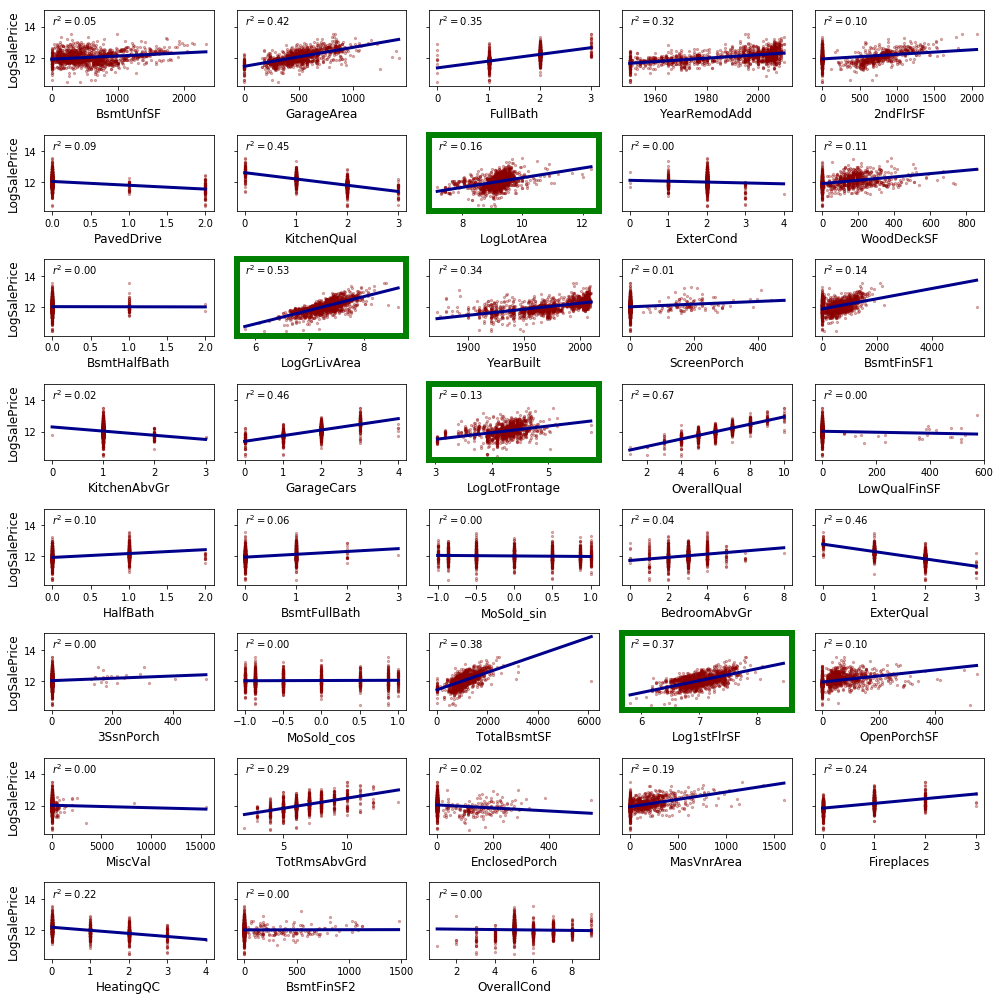

In [44]:
n_cols = 5
n_rows = int(np.ceil(len(new_numeric_cols) / n_cols))
fig, ax = plt.subplots(n_rows, n_cols, figsize=(14, 14), sharey=True)

# for a in ax.ravel():
#      a.set_yticks([])

id_row = 0
id_col = 0
ax[id_row, id_col].set_ylabel('LogSalePrice', fontsize=12)
for i, sp in enumerate({var for var in new_numeric_cols if var != 'LogSalePrice'}):
    
    x_train = initial_train[sp].values
    use_logic = np.isfinite(x_train)
    x_train = x_train[use_logic]
    y_train = initial_train['LogSalePrice'].values[use_logic]
    x_min, x_max = x_train.min(), x_train.max()
    lr = LinearRegression()
    lr.fit(x_train.reshape(-1, 1), y_train)
    preds_train = lr.predict(x_train.reshape(-1, 1))
    r2_val = r2_score(y_train, preds_train)
    y_lbf_low, y_lbf_high = lr.predict(np.array([x_min, x_max]).reshape(-1, 1))
    
    ax[id_row, id_col].scatter(initial_train[sp], initial_train['LogSalePrice'], color='darkred', alpha=0.3, s=5)
    ax[id_row, id_col].set_xlabel(sp, fontsize=12)
    ax[id_row, id_col].plot([x_min, x_max], [y_lbf_low, y_lbf_high], color='darkblue', linewidth=3)
    ax[id_row, id_col].text(0.05, 0.8, '$r^{} = {:.2f}$'.format(2, r2_val), transform=ax[id_row, id_col].transAxes)
    
    if sp.startswith('Log'): 
        for spine in ax[id_row, id_col].spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(6)

    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
        if i < (n_cols * n_rows - 1):
            ax[id_row, id_col].set_ylabel('LogSalePrice', fontsize=12)
    else:
        id_col += 1
    
    
for k in np.arange(i - 1, n_rows * n_cols - 2):
    
    fig.delaxes(ax[id_row, id_col])
    
    # update row and column count
    if id_col == n_cols - 1:
        id_row += 1
        id_col = 0
    else:
        id_col += 1
        
    
        
plt.tight_layout()
plt.show()

As we can see from these transformations (edited variables are have had their plots highlighted in green), the fits generally appear to be better than the above. Similarly, outliers for these seem less prominent. As a result, I won't remove any outliers at this stage, but it is worth bearing in mind improvements could be garnered by looking in more detail at possible outlier values.

In [45]:
initial_test['LogLotFrontage'] = np.log(initial_test['LotFrontage'])
initial_test['LogGrLivArea'] = np.log(initial_test['GrLivArea'])
initial_test['LogLotArea'] = np.log(initial_test['LotArea'])
initial_test['Log1stFlrSF'] = np.log(initial_test['1stFlrSF'])

### Quantifying and investigating relationships
As I've already log transformed the response, I will look at correlations using Spearman rank correlation, which is invariant under monotonic transforms.

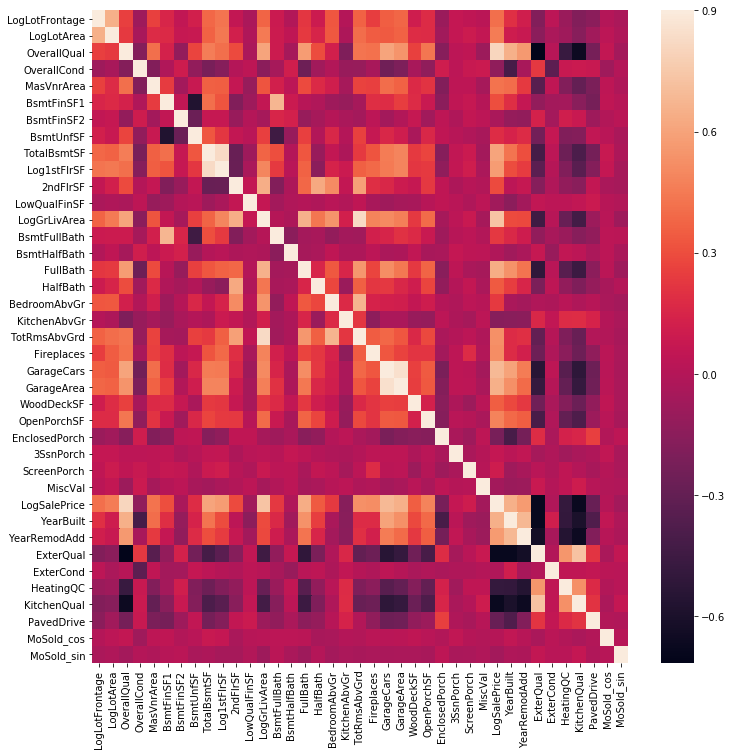

(39, 39)


In [46]:
fig = plt.figure(figsize=(12,12))
correlation_matrix = initial_train[new_numeric_cols].corr(method='spearman')
sns.heatmap(correlation_matrix, vmax=0.9)
plt.show()
correlation_matrix.head()
print(correlation_matrix.shape)

This shows us all numeric variables' correlations with each other, however it can be a little bit difficult to interpret.

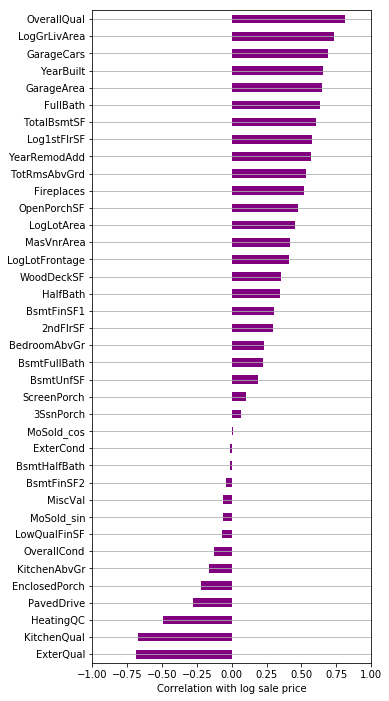

In [47]:
corr_with_target = correlation_matrix['LogSalePrice'].drop('LogSalePrice')

fig = plt.figure(figsize=(5,12)) 
corr_with_target.sort_values(ascending=True).plot(kind='barh', color='purple')
plt.xlim(-1, 1)
plt.xlabel('Correlation with log sale price')
plt.grid(axis='y')
plt.show()

Now is a good time to select some correlated feature variables to remove because the correlations between some of them may introduce multicollinearity which can impede the model results. For now, look at features with high correlation between themselves:

In [48]:
correlation_matrix_small = correlation_matrix.copy().drop(['LogSalePrice']).drop(columns=['LogSalePrice']).unstack()
correlation_matrix_small = correlation_matrix_small[(correlation_matrix_small.abs() > 0.7) & (correlation_matrix_small != 1)]
correlation_matrix_small.sort_values(ascending=False)

GarageArea    GarageCars      0.853486
GarageCars    GarageArea      0.853486
Log1stFlrSF   TotalBsmtSF     0.829112
TotalBsmtSF   Log1stFlrSF     0.829112
TotRmsAbvGrd  LogGrLivArea    0.828023
LogGrLivArea  TotRmsAbvGrd    0.828023
KitchenQual   ExterQual       0.726040
ExterQual     KitchenQual     0.726040
              OverallQual    -0.715961
OverallQual   ExterQual      -0.715961
dtype: float64

It appears from this that we might want to remove a couple of redundant variables. For example, 'GarageArea' is strongly correlated with 'GarageCars' so we will remove this variable (as it is itself slightly less correlated than 'GarageCars' with the sales price). Similarly, we will drop '1stFlrSF' and 'TotRmsAbvGrd'. 

In [49]:
drop_numeric_cols = ['GarageArea', 'Log1stFlrSF', 'TotRmsAbvGrd']
initial_train.drop(columns=drop_numeric_cols, inplace=True)
initial_test.drop(columns=drop_numeric_cols, inplace=True)

new_numeric_cols = [col for col in new_numeric_cols if col not in drop_numeric_cols]

Quite a few features have strong correlation with the house price. Before investigating some of the top ones further, we can check which are ordinal and which are continuous by assuming those with few unique values relative to the total observations are discrete.

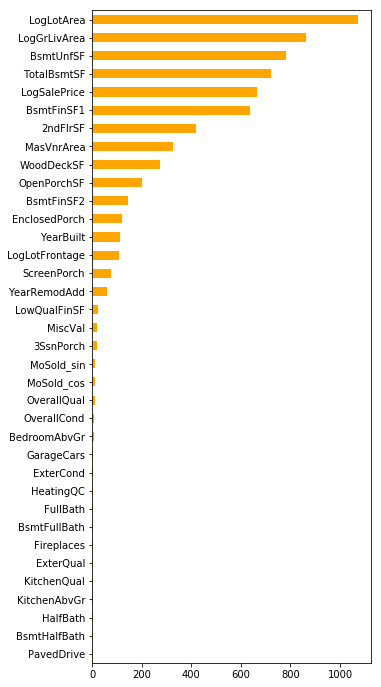

In [50]:
cols_numeric_uniques = initial_train[new_numeric_cols].nunique().sort_values()
fig = plt.figure(figsize=(5,12)) 
cols_numeric_uniques.plot(kind='barh', color='orange')
plt.show()

With the caveat that some continuous variables might appear to have low numbers due to potentially mostly being zero, we can see there are several variables which might actually be ordinal. Looking into 'OverallQual', the variable most correlated with the sales price:

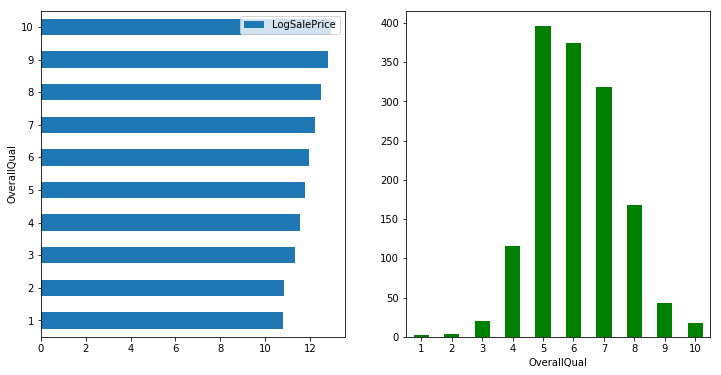

In [51]:
overqual_means = initial_train[['LogSalePrice','OverallQual']].groupby('OverallQual').mean()
overqual_counts = initial_train.groupby('OverallQual').size()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
overqual_means.plot(kind='barh', ax=ax1)
overqual_counts.plot(kind='bar', ax=ax2, rot=0, color='g')
plt.show()

Note that we are using the natural logarithm of the 'SalePrice' so differences may look slightly less clear than if we weren't, but it can clearly be seen that a higher overall quality is worth more!

In [52]:
continuous_vars = cols_numeric_uniques[(cols_numeric_uniques >= 50)].index
discrete_vars = cols_numeric_uniques[~(cols_numeric_uniques >= 50)].index
print(continuous_vars)

Index(['YearRemodAdd', 'ScreenPorch', 'LogLotFrontage', 'YearBuilt',
       'EnclosedPorch', 'BsmtFinSF2', 'OpenPorchSF', 'WoodDeckSF',
       'MasVnrArea', '2ndFlrSF', 'BsmtFinSF1', 'LogSalePrice', 'TotalBsmtSF',
       'BsmtUnfSF', 'LogGrLivArea', 'LogLotArea'],
      dtype='object')


In conclusion for the numeric variables, I will do the following:
- consider ordinal variables as okay to be used as I am using the continuous variables
- the log-transformed independent variables will be used where they exist instead of their originals
- the remaining of the numeric variables which haven't yet been dropped, will be put into the models as they are not overly-correlated with other (numeric) variables. It may be worth seeing if any others are correlated with the categorical ones.

In [53]:
initial_train.drop(columns=['LotFrontage', 'GrLivArea', 'LotArea', '1stFlrSF'], inplace=True)
initial_test.drop(columns=['LotFrontage', 'GrLivArea', 'LotArea', '1stFlrSF'], inplace=True)

### Dealing with missing values

In [54]:
still_missing_train = initial_train.isna().mean().sort_values(ascending=False)
print(still_missing_train[still_missing_train > 0])

LogLotFrontage    0.177519
MasVnrArea        0.005483
dtype: float64


We still have missing values for two variables. The Lot frontage is missing for about 18% in the training dataset, so we need to impute this somehow (there is still enough non-missings to make it worth not dropping the feature entirely). On the other hand, the `MasVnrArea` has very few missing values, so I will impute this using the mean of the training set.

In [55]:
mean_masvnrarea = initial_train.loc[~initial_train['MasVnrArea'].isna(), 'MasVnrArea'].mean()
print('Mean value of MasVnrArea: {:.1f}'.format(mean_masvnrarea))
initial_train['MasVnrArea'].fillna(mean_masvnrarea, inplace=True)

Mean value of MasVnrArea: 103.8


For the frontage there is not a huge amount of correlation with the response so I will not put too much effort into finding optimal missing values. However, I will perform a very simple linear regression to impute the missing values based upon the most correlated column with the lot frontage.

In [56]:
corr_with_lotfrontage = correlation_matrix['LogLotFrontage'].abs().sort_values(ascending=False)[1:]
corr_with_lotfrontage.head(3)

LogLotArea      0.649683
Log1stFlrSF     0.428300
LogSalePrice    0.409058
Name: LogLotFrontage, dtype: float64

Surprise, surprise. The lot area is most correlated with the lot frontage. Visualising the relationship:

<Figure size 576x360 with 0 Axes>

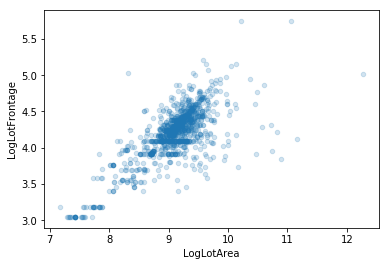

In [57]:
plt.figure(figsize=(8, 5))
initial_train.plot.scatter(x='LogLotArea', y='LogLotFrontage', alpha=0.2)
plt.show()

We can fit a quick linear regression to this to get an estimate of a missing value for `LogLotFrontage` from that of `LotArea`. I will not spend too long doing this, nor will I do any complex model assessment. However, I will deal with outliers in the above plot by only using training data with up to 11 log lot area and 5.5 log lot frontage.

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

use_in_lot_model = initial_train[['LogLotArea', 'LogLotFrontage']].dropna()
use_in_lot_model_x = use_in_lot_model.loc[(use_in_lot_model['LogLotArea'] <= 11) &
                                          (use_in_lot_model['LogLotFrontage'] <= 5.5), 'LogLotArea'].values
use_in_lot_model_y = use_in_lot_model.loc[(use_in_lot_model['LogLotArea'] <= 11) &
                                          (use_in_lot_model['LogLotFrontage'] <= 5.5), 'LogLotFrontage'].values
linreg_lot = LinearRegression()
linreg_lot.fit(use_in_lot_model_x.reshape(-1, 1), use_in_lot_model_y)
lot_model_train_res = linreg_lot.predict(use_in_lot_model_x.reshape(-1, 1))

print("R-squared on the training data: {:.2f}".format(r2_score(use_in_lot_model_y,lot_model_train_res)))

initial_train['ImputedLogLotFrontage'] = linreg_lot.predict(initial_train['LogLotArea'].values.reshape(-1, 1))
lot_model_line = lambda x: linreg_lot.intercept_ + x * linreg_lot.coef_[0]

R-squared on the training data: 0.56


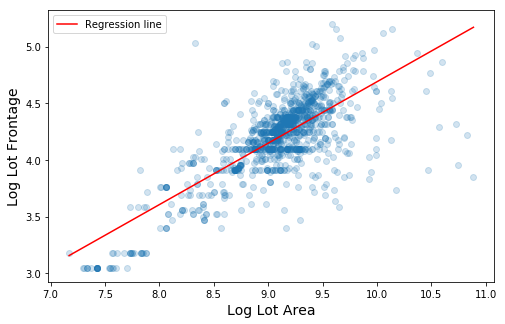

In [59]:
plt.figure(figsize=(8, 5))
# initial_train.plot.scatter(x='LotArea', y='LogLotFrontage', alpha=0.2)
plt.scatter(use_in_lot_model_x, use_in_lot_model_y, alpha=0.2)
xvals = np.array([use_in_lot_model_x.min(), use_in_lot_model_x.max()])
yvals = lot_model_line(xvals)
plt.plot(xvals, yvals, color='red', label='Regression line')
plt.xlabel('Log Lot Area', fontsize=14)
plt.ylabel('Log Lot Frontage', fontsize=14)
plt.legend()
plt.show()

In [60]:
initial_train['LogLotFrontage'].fillna(initial_train['ImputedLogLotFrontage'], inplace=True)

### Checking the test data

In [61]:
still_missing_test = initial_test.isna().mean().sort_values(ascending=False)
print(still_missing_test[still_missing_test > 0])

LogLotFrontage    0.155586
MasVnrArea        0.010281
BsmtFullBath      0.001371
BsmtHalfBath      0.001371
BsmtFinSF2        0.000685
BsmtUnfSF         0.000685
TotalBsmtSF       0.000685
BsmtFinSF1        0.000685
GarageCars        0.000685
dtype: float64


There are a few missing data points for several columns. The `MasVnrArea` and `LotFrontage` can be fixed by using the same procedure as above.

In [62]:
initial_test['MasVnrArea'].fillna(mean_masvnrarea, inplace=True)
initial_test['ImputedLogLotFrontage'] = linreg_lot.predict(initial_test['LogLotArea'].values.reshape(-1, 1))
initial_test['LogLotFrontage'].fillna(initial_test['ImputedLogLotFrontage'], inplace=True)

However, we have a few new variables missing values we need to fix.

In [63]:
still_missing_test = initial_test.isna().sum().sort_values(ascending=False)
print(still_missing_test[still_missing_test > 0])

BsmtFullBath    2
BsmtHalfBath    2
GarageCars      1
BsmtUnfSF       1
BsmtFinSF2      1
BsmtFinSF1      1
TotalBsmtSF     1
dtype: int64


Again, as there are so few missing values, I will replace them with their respective mean (from the training set).

In [64]:
initial_test['BsmtHalfBath'].fillna(initial_train['BsmtHalfBath'].mean(), inplace=True)
initial_test['BsmtFullBath'].fillna(initial_train['BsmtFullBath'].mean(), inplace=True)
initial_test['BsmtFinSF2'].fillna(initial_train['BsmtFinSF2'].mean(), inplace=True)
initial_test['BsmtUnfSF'].fillna(initial_train['BsmtUnfSF'].mean(), inplace=True)
initial_test['TotalBsmtSF'].fillna(initial_train['TotalBsmtSF'].mean(), inplace=True)
initial_test['BsmtFinSF1'].fillna(initial_train['BsmtFinSF1'].mean(), inplace=True)
initial_test['GarageCars'].fillna(initial_train['GarageCars'].mean(), inplace=True)

In [65]:
cleaned_numeric_cols = new_numeric_cols
cleaned_cat_cols = remaining_cat_cols
cleaned_cat_cols_ohe = list(train_ohe.columns)

### Feature engineering
While we already have lots of features in our data set, it is always worth stopping to think whether there may be anything calculable which may also be a useful predictor.

A reminder of our columns:

In [66]:
(cleaned_numeric_cols + cleaned_cat_cols)

['LogLotFrontage',
 'LogLotArea',
 'OverallQual',
 'OverallCond',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'LogGrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal',
 'LogSalePrice',
 'YearBuilt',
 'YearRemodAdd',
 'ExterQual',
 'ExterCond',
 'HeatingQC',
 'KitchenQual',
 'PavedDrive',
 'MoSold_cos',
 'MoSold_sin',
 'MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFini

In [67]:
train_ohe.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,GarageCond_None,GarageCond_Po,GarageCond_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSS

In [68]:
initial_train.head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,YrSold,SaleType,SaleCondition,LogSalePrice,HasMiscFeature,HasFence,MoSold_cos,MoSold_sin,LogLotFrontage,LogGrLivArea,LogLotArea,ImputedLogLotFrontage
0,60,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,1,2,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,0,Y,SBrkr,854,0,1,0,2,1,3,1,1,Typ,0,None,Attchd,RFn,2,TA,TA,0,0,61,0,0,0,0,2008,WD,Normal,12.247694,0,0,5.000000e-01,8.660254e-01,4.174387,7.444249,9.041922,4.170925
1,20,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,0,Y,SBrkr,0,0,0,1,2,0,3,1,2,Typ,1,TA,Attchd,RFn,2,TA,TA,0,298,0,0,0,0,0,2007,WD,Normal,12.109011,0,0,-8.660254e-01,5.000000e-01,4.382027,7.140453,9.169518,4.240111
2,60,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,1,2,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,0,Y,SBrkr,866,0,1,0,2,1,3,1,1,Typ,1,TA,Attchd,RFn,2,TA,TA,0,0,42,0,0,0,0,2008,WD,Normal,12.317167,0,0,-1.836970e-16,-1.000000e+00,4.219508,7.487734,9.328123,4.326110
3,70,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,1,Y,SBrkr,756,0,1,0,1,0,3,1,1,Typ,1,Gd,Detchd,Unf,3,TA,TA,0,0,35,272,0,0,0,2006,WD,Abnorml,11.849398,0,0,5.000000e-01,8.660254e-01,4.094345,7.448334,9.164296,4.237279
4,60,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,1,2,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,0,Y,SBrkr,1053,0,1,0,2,1,4,1,1,Typ,1,TA,Attchd,RFn,3,TA,TA,0,192,84,0,0,0,0,2008,WD,Normal,12.429216,0,0,1.000000e+00,-2.449294e-16,4.430817,7.695303,9.565214,4.454666


## Linreg assumptions

In [69]:
train_ohe.shape

(1459, 252)

In [70]:
initial_train.shape

(1459, 76)

# Models
Caveat, when cross-validation is used, data from the validation fold will inevtably have been used for feature creation/manipulation/missing filling above.

In [82]:
feature_cols = cleaned_numeric_cols + cleaned_cat_cols_ohe
response_col = 'LogSalePrice'

full_model_set_train = pd.concat((initial_train[[response_col] + cleaned_numeric_cols], train_ohe), sort=False, axis=1)
full_model_set_train.shape
full_model_set_train.head()

,LogSalePrice,LogLotFrontage,LogLotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,LogGrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,LogSalePrice,YearBuilt,YearRemodAdd,ExterQual,ExterCond,HeatingQC,KitchenQual,PavedDrive,MoSold_cos,MoSold_sin,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_None,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_AllPub,Utilities_NoSeWa,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_ClyTile,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,FireplaceQu_Ex,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Po,FireplaceQu_TA,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Ex,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,GarageCond_Ex,GarageCond_Fa,GarageCond_Gd,G

The evaluation metric is the root mean square error between the log of the predicted price and the log of the true price.

In [83]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

scorer = make_scorer(mean_squared_error, greater_is_better=False)
